# Fine tuning classification with OpenAI

We will fine-tune some OpenAI classifier to classify the number of stars a reviewer will give a review of an app

In [17]:
# Importing necessary libraries
import pandas as pd  # Used for data manipulation and analysis
from openai import OpenAI  # OpenAI's API for accessing its AI models
import os  # Provides functions to interact with the operating system
from datasets import load_dataset  # Library to load and preprocess datasets
import random  # Provides functions for generating random numbers
import math  # Provides mathematical functions
import matplotlib.pyplot as plt
import json
import seaborn as sns  # Seaborn provides a higher-level interface for styling plots
import numpy as np
from tqdm.auto import tqdm
import math

# Setting the style to a modern look
sns.set_style("whitegrid")

# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)


In [18]:
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [19]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset


Found cached dataset parquet (/Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-c7d4d3a6b1c12ac8.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-6f7d6dd258fd58db.arrow


Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [20]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset


Loading cached split indices for dataset at /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-db7553cfcc7860a4.arrow and /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-2960ea48d9a425ee.arrow
Loading cached split indices for dataset at /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-aa36e58e1017a1b1.arrow and /Users/sinanozdemir/.cache/huggingface/datasets/parquet/app_reviews-444711a5c0608be8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-0d55c33aae5c7107.arrow


DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [21]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df.head()

,package_name,review,date,star
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0
4,com.google.android.gms,Ok,April 29 2017,2


In [22]:
training_df[['review']].sample(5)

,review
34740,Strangely Broken Can play Sonic Adventure 2 n...
4921,Good app which give a great view of the night ...
164418,Needs checkpoints 3rd boss already lost my ank...
45456,Its easy to use
80866,Loved it


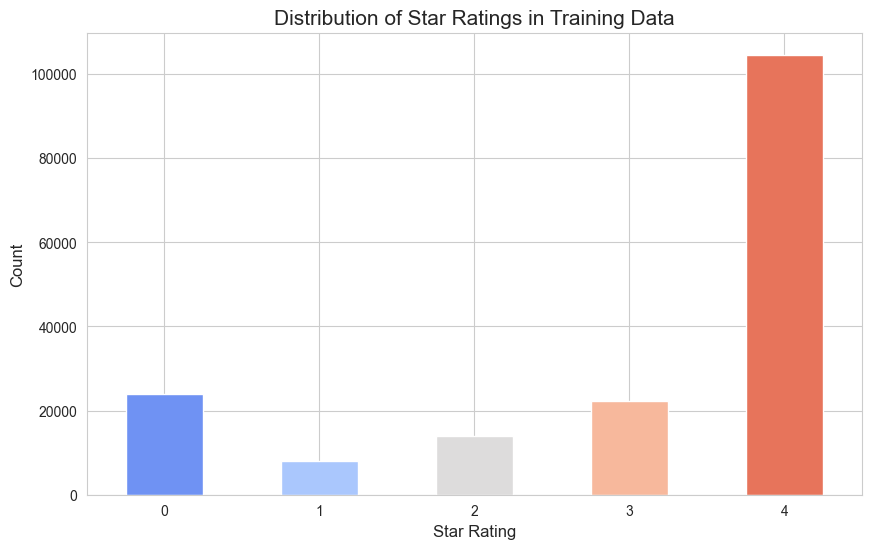

In [23]:
# Counting the number of occurrences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# Creating the bar plot to show distribution of star ratings given
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
star_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(star_counts)))

# Adding titles and labels for clarity
plt.title('Distribution of Star Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)  # Ensure the x-axis labels are horizontal for better readability

# Displaying the chart
plt.show()


In [24]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

# Star prediction (sentiment)

In [25]:
# Creating the 'prompt' column in each dataset (training, validation, and test) by adding a separator '###\n' to the 'review' column.
# This separator is often used in fine-tuning to signal where the prompt ends and the expected output begins.
training_df['prompt'] = training_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'

# Converting the 'star' column in each dataset to a string format and storing it in the 'completion' column.
# The 'completion' column will be used as the target variable for sentiment analysis.
training_df['completion'] = training_df['star'].astype(str)  # for sentiment
val_df['completion'] = val_df['star'].astype(str)  # for sentiment
test_df['completion'] = test_df['star'].astype(str)  # for sentiment

# Creating a training dataset in JSONL format after dropping duplicates based on the 'prompt' column.
# Random sampling ensures the data is shuffled.
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient='records', lines=True
)

# Creating another version of the training dataset in JSONL format, but this time ordering by 'completion' column (star ratings).
# This ordered set might be useful for specific training strategies.
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].sort_values('completion').to_json(
    "app-review-full-train-sentiment-ordered.jsonl", orient='records', lines=True
)

# Creating a validation dataset in JSONL format after dropping duplicates based on the 'prompt' column.
val_df.sample(
    len(val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

# Creating a test dataset in JSONL format after dropping duplicates based on the 'prompt' column.
test_df.sample(
    len(test_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-test-sentiment-random.jsonl", orient='records', lines=True
)

In [26]:
training_df

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0,Mr Perfect\n###\n,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0,Does not work with Tmobile S4 If you try to in...,0
4,com.google.android.gms,Ok,April 29 2017,2,Ok\n###\n,2
...,...,...,...,...,...,...
172834,com.nilhcem.hostseditor,9c Ok,January 15 2016,4,9c Ok\n###\n,4
172835,org.thialfihar.android.apg,GRATE Start 1st off I waited a few weeks to te...,December 12 2014,2,GRATE Start 1st off I waited a few weeks to te...,2
172836,com.google.android.gms,Gtty,November 20 2016,4,Gtty\n###\n,4
172837,com.google.android.gms,OK,March 05 2017,4,OK\n###\n,4


In [27]:
def get_data_dict(row, system=''):
    return {
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

In [28]:
# export 3.5 prompts with no system prompt
with open(f'app-review-full-train-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

In [29]:
# export 3.5 prompts with a system prompt
system_prompt = 'You predict star ratings given an app review from 0-4 where 0 means the review would give the worst rating and 4 means the best rating'
# 31 extra tokens PER example
with open(f'app-review-full-train-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))  # Create a dictionary for each row
        f.write(json_str + '\n')  # Write JSON string to a file

In [30]:
print(training_df['prompt'].iloc[0])

Nice😉
###



In [31]:
training_df['star'].iloc[0]

4

# Using OpenAI's Fine-tuning API

In [32]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random.jsonl", "rb").readlines()[0])

{'prompt': 'Its good\n###\n', 'completion': '3'}

In [ ]:
client

In [37]:
# Creating a file object for the training dataset with OpenAI's API.
# The 'file' parameter specifies the path to the training data in JSONL format.
# The 'purpose' is set to 'fine-tune', indicating the file's intended use.
training_file = client.files.create(
  file=open("app-review-full-train-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
val_file = client.files.create(
  file=open("app-review-full-val-sentiment-random.jsonl", "rb"),
  purpose='fine-tune'
)


In [257]:
# Initiating the fine-tuning process with OpenAI's API.

# The `client.fine_tuning.jobs.create method is used to start the training.
# Parameters include:
# - `training_file`: The ID of the previously uploaded training dataset file.
# - `validation_file`: The ID of the previously uploaded validation dataset file.
# - `model`: The base model to be fine-tuned. In this case, "babbage-002" is chosen.
# - `hyperparameters`: Dictionary containing training hyperparameters. Here, we specify the number of epochs as 1.
job = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=val_file.id,
    model="babbage-002",
    hyperparameters={'n_epochs': 1}
)



In [367]:
# Retrieving details of an ongoing or completed fine-tuning job using OpenAI's API.

# The `client.fine_tuning.retrieve.retrieve` method fetches the job details based on its ID.
# This can be used to monitor the progress, status, or retrieve results of the training job.
job = client.fine_tuning.jobs.retrieve(job.id)


In [40]:
job

FineTuningJob(id='ftjob-H8qk5ylqK4WC5CZqZbdHoI34', created_at=1698416338, error=None, fine_tuned_model='ft:babbage-002:personal::8EJokS4B', finished_at=1698423460, hyperparameters=Hyperparameters(n_epochs=1, batch_size=90, learning_rate_multiplier=2), model='babbage-002', object='fine_tuning.job', organization_id='org-azQm6jrJ3FSBpJAwYcgxQxGu', result_files=['file-X7wJXtZmKpF04r0Egc0X0m3l'], status='succeeded', trained_tokens=2833557, training_file='file-OynKOPOBvIesnfq0Ubsu3p9n', validation_file='file-yF5vsOt3IMOhJs2jFeK46nWo')

In [41]:
job.id

'ftjob-H8qk5ylqK4WC5CZqZbdHoI34'

In [53]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-H8qk5ylqK4WC5CZqZbdHoI34"):
    print(event)
    print('---')

FineTuningJobEvent(id='ftevent-zTLF7f5eKffMUUTD7qWhbPKu', created_at=1698423465, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
---
FineTuningJobEvent(id='ftevent-hqFVXm5UFD8kbo0tvxyqdGPj', created_at=1698423463, level='info', message='New fine-tuned model created: ft:babbage-002:personal::8EJokS4B', object='fine_tuning.job.event', data={}, type='message')
---
FineTuningJobEvent(id='ftevent-JKmXVtxPBR3I80nH6l6gVlTJ', created_at=1698423455, level='info', message='Step 1501/1501: training loss=1.07, validation loss=0.74', object='fine_tuning.job.event', data={'step': 1501, 'train_loss': 1.0739907026290894, 'valid_loss': 0.7359817861061957, 'train_mean_token_accuracy': 0.5681818127632141, 'valid_mean_token_accuracy': 0.7555555555555555}, type='metrics')
---
FineTuningJobEvent(id='ftevent-eBgKJTvQAsqU1PrKUAO2WftU', created_at=1698423426, level='info', message='Step 1401/1501: training loss=0.73, validation loss=0.66', ob

In [42]:
if len(job.result_files):
    print(job.result_files)

['file-X7wJXtZmKpF04r0Egc0X0m3l']


In [70]:
# Downloading the results of the completed fine-tuning job using OpenAI's API.

# The `client.files.retrieve_content` method is used to fetch the result files.
# `job.result_files[0]` gets the ID of the first result file associated with the job.
results = client.files.retrieve_content(job.result_files[0])

# Saving the decoded results into a CSV file.
# Opening (or creating) a file named 'results.csv' in write mode.
with open('results.csv', 'w') as f:
    f.write(results)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_44017/1863415972.py:5: DeprecationWarning: The `.content()` method should be used instead
  results = client.files.retrieve_content(job.result_files[0])


In [58]:
results_df = pd.read_csv('results.csv')

results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.37326,0.37778,2.09622,0.47778
1,2,2.51663,0.37778,NaN,NaN
2,3,2.24874,0.38889,NaN,NaN
3,4,2.39119,0.41111,NaN,NaN
4,5,2.41051,0.41111,NaN,NaN


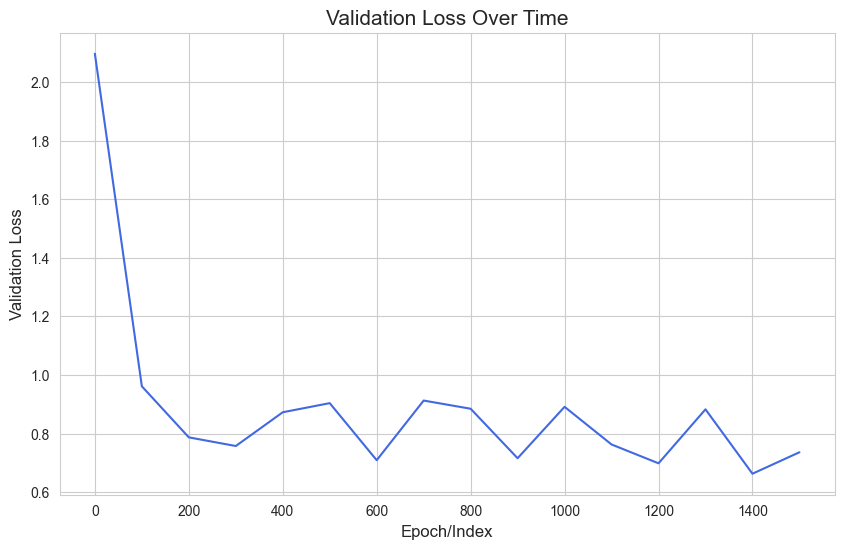

In [59]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['valid_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()


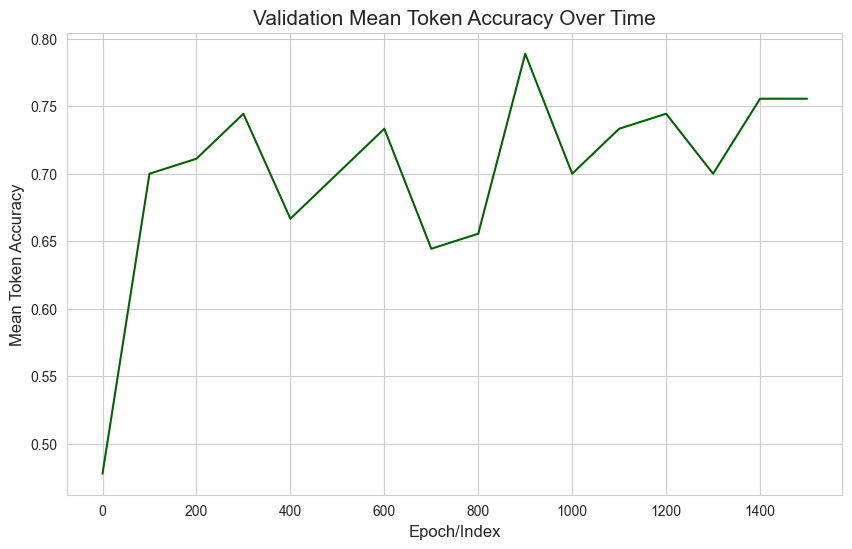

In [375]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


# Further fine-tune our Babbage model for 3 more epochs

In [321]:
job = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=val_file.id,
    model=job.fine_tuned_model,
    hyperparameters={'n_epochs': 3}
)

In [607]:
job.id

'ftjob-gpkNo58LXUqLfoqq6eB5TQYb'

In [376]:
job = client.fine_tuning.jobs.retrieve(job.id)
print(job)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    with open('results.csv', 'w') as f:
        f.write(results)
    results_df = pd.read_csv('results.csv')


results_df.head()

{
  "object": "fine_tuning.job",
  "id": "ftjob-gpkNo58LXUqLfoqq6eB5TQYb",
  "model": "ft:babbage-002:personal::8EJokS4B",
  "created_at": 1698424950,
  "finished_at": 1698426137,
  "fine_tuned_model": "ft:babbage-002:personal::8EKVvxZv",
  "organization_id": "org-azQm6jrJ3FSBpJAwYcgxQxGu",
  "result_files": [
    "file-FParttlSDumS7dFkjW7UWXDF"
  ],
  "status": "succeeded",
  "validation_file": "file-yF5vsOt3IMOhJs2jFeK46nWo",
  "training_file": "file-OynKOPOBvIesnfq0Ubsu3p9n",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": 8500671,
  "error": null
}
['file-FParttlSDumS7dFkjW7UWXDF']


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,0.73162,0.75781,0.74559,0.71875
1,2,0.80441,0.71094,NaN,NaN
2,3,0.89888,0.66406,NaN,NaN
3,4,0.76620,0.72656,NaN,NaN
4,5,0.82754,0.68750,NaN,NaN


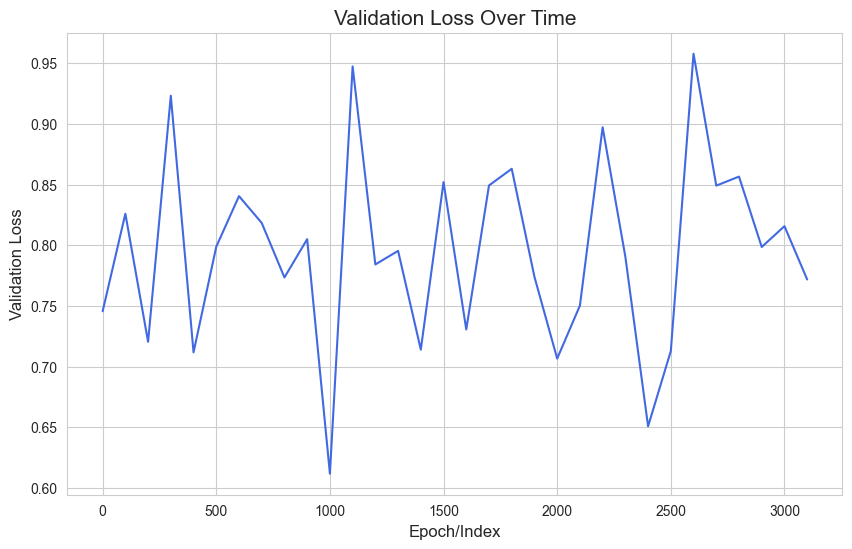

In [377]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['valid_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()


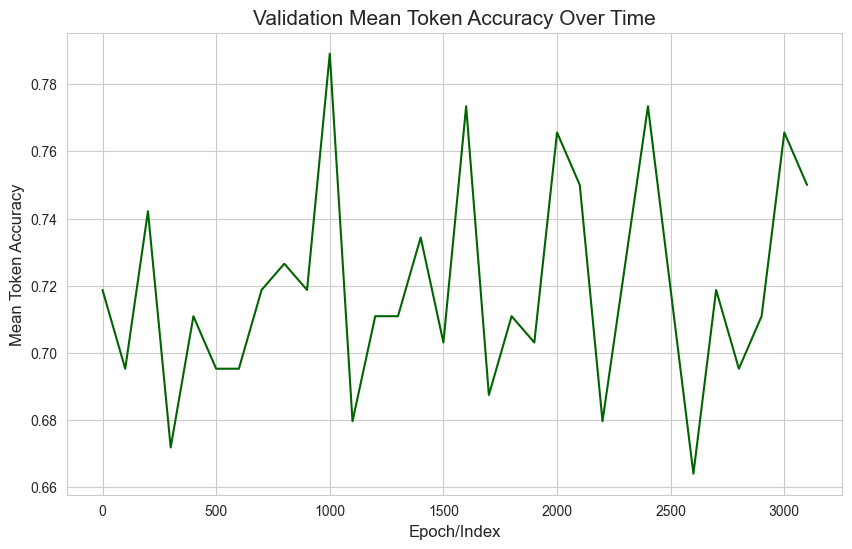

In [378]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


In [ ]:
# basically no change in performance..

# Let's see what happens if the data was sorted by star

In [ ]:
# in the legacy API, you had to shuffle the data yourself before uploading it or else you were 
#  subject to severely worse performance from the fine-tuning

# Let's see if this is still true..

In [304]:
# Upload a new file that is specifically sorted by star
ordered_training_file = client.files.create(
  file=open("app-review-full-train-sentiment-ordered.jsonl", "rb"),
  purpose='fine-tune'
)

In [305]:
job = client.fine_tuning.jobs.create(
    training_file=ordered_training_file.id,
    validation_file=val_file.id,
    model='babbage-002',
    hyperparameters={'n_epochs': 1}
)


In [608]:
job.id

'ftjob-qdXc2PVcEl3ENr9b1YemfGEr'

In [379]:
job = client.fine_tuning.jobs.retrieve(job.id)
print(job)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    with open('results.csv', 'w') as f:
        f.write(results)
    results_df = pd.read_csv('results.csv')

results_df.head()

{
  "object": "fine_tuning.job",
  "id": "ftjob-qdXc2PVcEl3ENr9b1YemfGEr",
  "model": "babbage-002",
  "created_at": 1698422344,
  "finished_at": 1698428920,
  "fine_tuned_model": "ft:babbage-002:personal::8ELEnbVw",
  "organization_id": "org-azQm6jrJ3FSBpJAwYcgxQxGu",
  "result_files": [
    "file-mUr8uYRZGeAjt5CTrHpEwEta"
  ],
  "status": "succeeded",
  "validation_file": "file-yF5vsOt3IMOhJs2jFeK46nWo",
  "training_file": "file-JRecjWOWPenIwB6A5zEhmWz2",
  "hyperparameters": {
    "n_epochs": 1
  },
  "trained_tokens": 2833557,
  "error": null
}
['file-mUr8uYRZGeAjt5CTrHpEwEta']


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.20046,0.51111,2.09622,0.47778
1,2,2.57506,0.25556,NaN,NaN
2,3,2.10734,0.47778,NaN,NaN
3,4,2.60895,0.31111,NaN,NaN
4,5,2.28541,0.41111,NaN,NaN


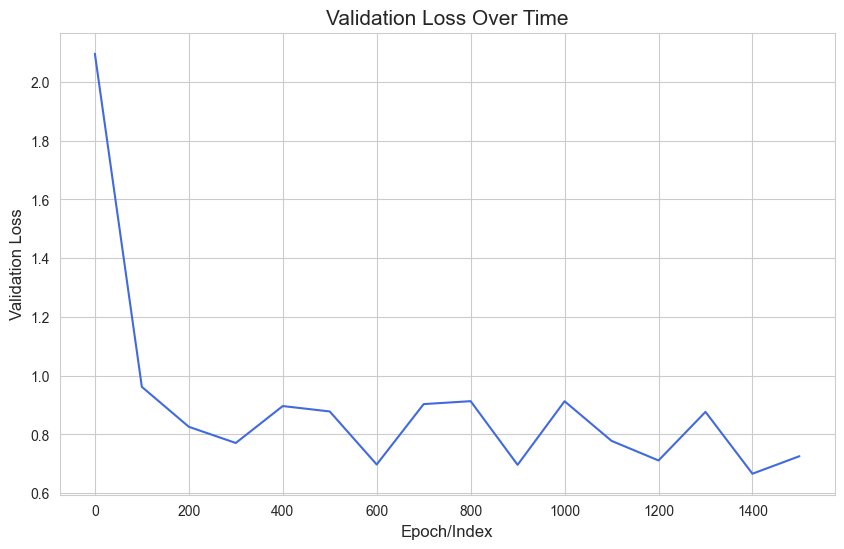

In [380]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['valid_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()


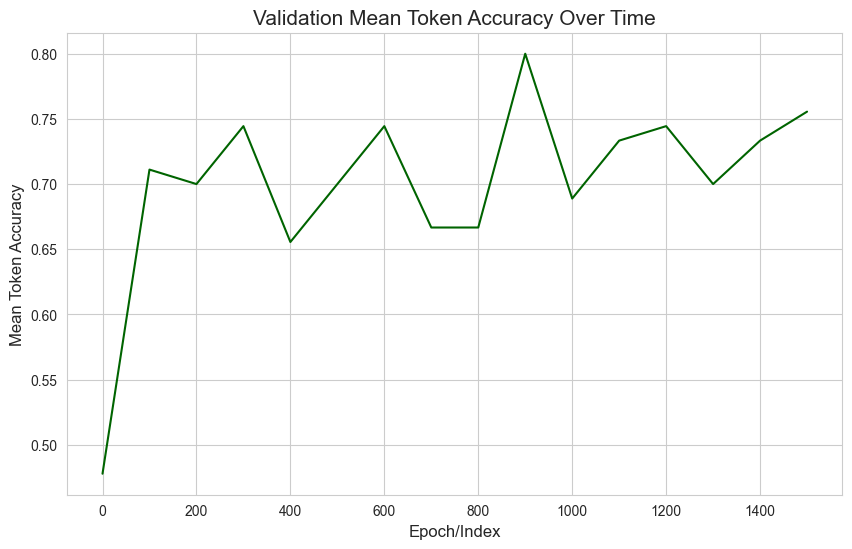

In [381]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


In [ ]:
# looks like about the same result. The legacy API showed a huge difference in performance but the new version
#  seems to be shuffling the data in the backend even though I can't find reference to this behavior in their documentation.
#  We love that though!

# 3.5 training - first with no system prompt

In [610]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random-3.5.jsonl", "rb").readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [451]:
# Upload our GPT 3.5 training data
training_file_3_5 = client.files.create(
  file=open("app-review-full-train-sentiment-random-3.5.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
val_file_3_5 = client.files.create(
  file=open("app-review-full-val-sentiment-random-3.5.jsonl", "rb"),
  purpose='fine-tune'
)

In [452]:
job = client.fine_tuning.jobs.create(
    training_file=training_file_3_5.id,
    validation_file=val_file_3_5.id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)


In [453]:
job.id

'ftjob-k1yjidnRUBB8OtldUTmTtPXm'

In [459]:
job = client.fine_tuning.jobs.retrieve(job.id)
print(job)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    with open('results.csv', 'w') as f:
        f.write(results)
    results_df = pd.read_csv('results.csv')

{
  "object": "fine_tuning.job",
  "id": "ftjob-k1yjidnRUBB8OtldUTmTtPXm",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1699021269,
  "finished_at": 1699032323,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal::8GsD6MhX",
  "organization_id": "org-azQm6jrJ3FSBpJAwYcgxQxGu",
  "result_files": [
    "file-mTlEML9tGO9bo2uErXfSFbfd"
  ],
  "status": "succeeded",
  "validation_file": "file-Uy4kKuUgtEokG3FShPuqyGNG",
  "training_file": "file-lezxzS3TNNroTXHBwfF2Z7ga",
  "hyperparameters": {
    "n_epochs": 1
  },
  "trained_tokens": 4985412,
  "error": null
}
['file-mTlEML9tGO9bo2uErXfSFbfd']


In [461]:
results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,4.24463,0.36232,4.60071,0.0
1,2,3.87384,0.35942,NaN,NaN
2,3,4.43191,0.36232,NaN,NaN
3,4,4.11990,0.36522,NaN,NaN
4,5,4.16018,0.35072,NaN,NaN


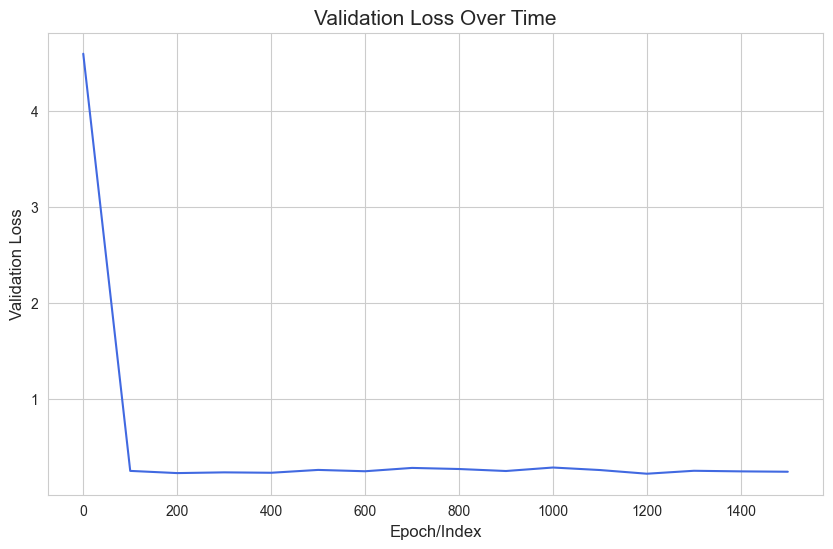

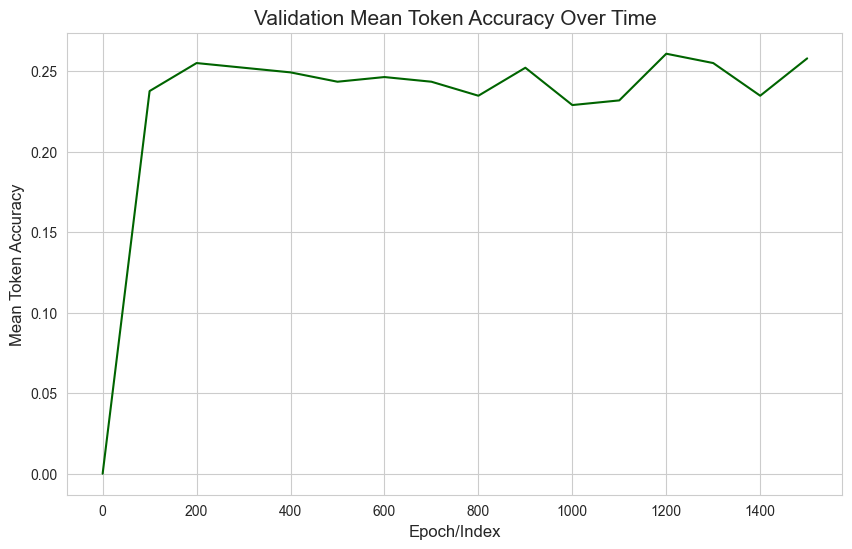

In [464]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['valid_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()

# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


# 3.5 training with a system prompt

In [612]:
# reminder of what this data looks like
json.loads(open("app-review-full-train-sentiment-random-3.5-system.jsonl", "rb").readlines()[0])

{'messages': [{'role': 'system',
   'content': 'You predict star ratings given an app review from 0-4 where 0 means the review would give the worst rating and 4 means the best rating'},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [498]:
training_file_3_5_system = client.files.create(
  file=open("app-review-full-train-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API.
val_file_3_5_system = client.files.create(
  file=open("app-review-full-val-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

In [499]:
job = client.fine_tuning.jobs.create(
    training_file=training_file_3_5_system.id,
    validation_file=val_file_3_5_system.id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)


In [500]:
job.id

'ftjob-ED2IHyq6vsHzDTQUQeSaHxbo'

In [515]:
job = client.fine_tuning.jobs.retrieve(job.id)
print(job)
results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    with open('results.csv', 'w') as f:
        f.write(results)
    results_df = pd.read_csv('results.csv')

{
  "object": "fine_tuning.job",
  "id": "ftjob-ED2IHyq6vsHzDTQUQeSaHxbo",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1699134693,
  "finished_at": 1699146913,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal::8HM1JKgr",
  "organization_id": "org-azQm6jrJ3FSBpJAwYcgxQxGu",
  "result_files": [
    "file-sOKK41WCQrgWL1AeDdErYqh7"
  ],
  "status": "succeeded",
  "validation_file": "file-kE0BTJcFt3FOI8AQKPhmrJHk",
  "training_file": "file-5S2BXVp2tdqd2qxh955c4uYT",
  "hyperparameters": {
    "n_epochs": 1
  },
  "trained_tokens": 10343421,
  "error": null
}
['file-sOKK41WCQrgWL1AeDdErYqh7']


In [517]:
results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.86116,0.44179,2.99447,0.11884
1,2,2.78176,0.45173,NaN,NaN
2,3,2.97844,0.43821,NaN,NaN
3,4,2.86732,0.46739,NaN,NaN
4,5,3.07915,0.44686,NaN,NaN


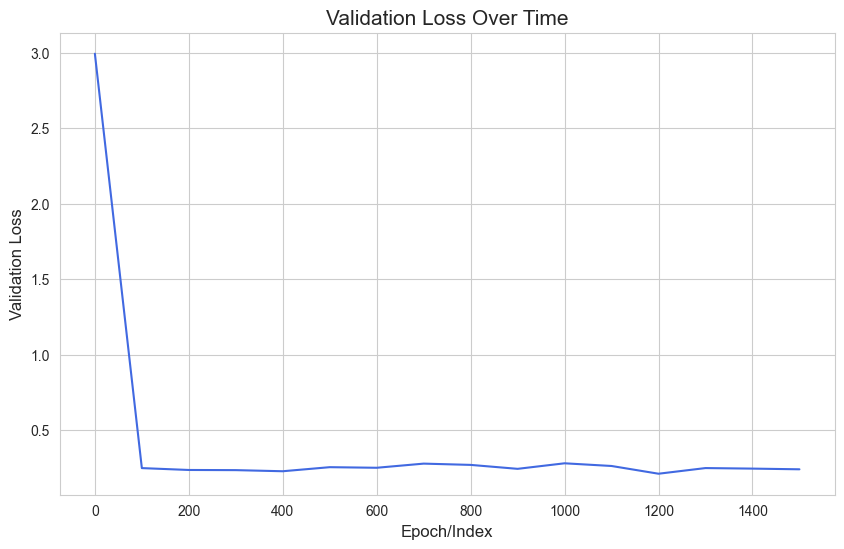

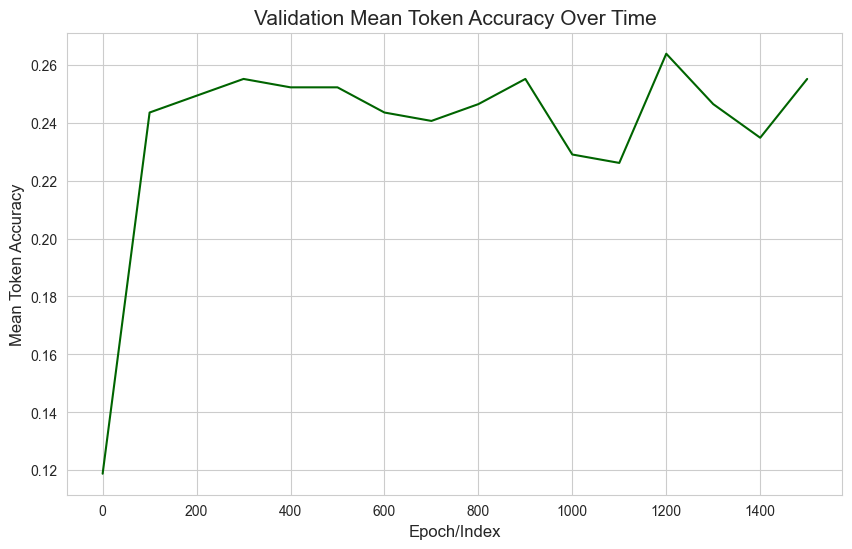

In [516]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))  # Setting a suitable figure size for better visibility
results_df['valid_loss'].dropna().plot(color="royalblue")

# Adding titles and labels for clarity
plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

# Displaying the plot
plt.show()

# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smooth, continuous plot.
plt.figure(figsize=(10, 6))  # Designating an optimal figure size for better clarity
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

# Adding titles and labels for clarity
plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Showcasing the plot
plt.show()


In [ ]:
# that mean token accuracy is interesting.. it claims to have a severely low accuracy but as we will see, this is not
#  true according to our testing set.. I frankly am not sure why this reported accuracy is so low

# Evalauting our classifier using test accuracy

In [614]:
# Importing the numpy library to perform mathematical operations
import numpy as np

# Define a function to run the fine-tuned model and get the model's response
def run_ft_model(review, ft_id, system='', chat=False):
    """
    Given a review and a fine-tuned model ID, this function uses OpenAI's Completion API to
    generate a completion. It also calculates the exponential of the top log probabilities for the completion.
    
    Parameters:
    - review (str): The text of the review.
    - ft_id (str): The ID of the fine-tuned model.
    
    Returns:
    - str: The completion generated by the model.
    - dict: A dictionary of tokens and their corresponding exponential of top log probabilities.
    """
    
    # Use OpenAI's API to create a completion using the fine-tuned model
    if chat:
        completion = client.chat.completions.create(
            model=ft_id,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": review}
            ],
            max_tokens=1,
            temperature=0.1
        )
        text = completion.choices[0].message.content.strip()
        return text, None
    else:
        completion = client.completions.create(
            model=ft_id,                   # Specify the fine-tuned model ID
            prompt=f'{review}\n###\n',     # Format the review with the prompt structure
            max_tokens=1,                  # Limit the response to 1 token (useful for classification tasks)
            temperature=0.1,               # Set a low temperature for deterministic output
            logprobs=5                     # Request the top 5 log probabilities for the completion
        )
        
        # Extract the model's completion text and strip any extra whitespace
        text = completion.choices[0].text.strip()
        
        # Convert the log probabilities to regular probabilities using the exponential function
        # This provides a clearer understanding of the model's confidence in its responses
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}
        
        return text, probs

# Example usage: Predict the sentiment and associated probabilities of the given review using the fine-tuned model
run_ft_model('I hated this thing it was the worst', 'ft:babbage-002:personal::8EJokS4B')  # babbage for one epoch

('0',
 {'0': 0.8948484765359231,
  '1': 0.06089519543934895,
  '4': 0.023477189237092196,
  '2': 0.01504005956544302,
  '3': 0.004622934048641707})

In [ ]:
# As of 11/5/2023 - pricing for fine-tuning (https://openai.com/pricing)

#    Model	         Training          	Input usage 	   Output usage
# babbage-002	$0.0004 / 1K tokens	$0.0016 / 1K tokens	$0.0016 / 1K tokens
# davinci-002	$0.0060 / 1K tokens	$0.0120 / 1K tokens	$0.0120 / 1K tokens
# GPT-3.5 Turbo	$0.0080 / 1K tokens	$0.0120 / 1K tokens	$0.0160 / 1K tokens

In [411]:
train_price_usd = 0.0004 * job.trained_tokens / 1_000
print(f'Price to train was ${train_price_usd}')

Price to train was $1.1334228


In [421]:
avg_tokens_per_input = job.trained_tokens / training_df.shape[0]
# output is always 1 token

avg_inference_price_usd = 0.0016 * (avg_tokens_per_input / 1_000) + (0.0016 / 1_000)
avg_inference_price_usd
print(f'Price for a single inference (on avg): ${avg_inference_price_usd} and cost to run test: ${avg_inference_price_usd * test_df.shape[0]}')

Price for a single inference (on avg): $2.7830718761390663e-05 and cost to run test: $1.6034112000000003


## Evaluating our models

In [ ]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, FINETUNED_MODEL_ID)
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


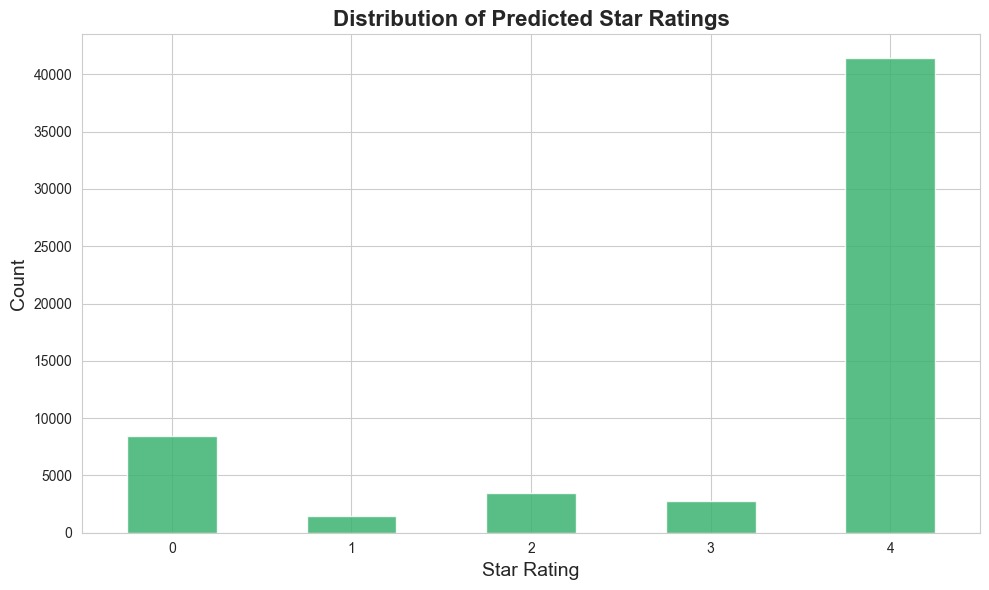

In [427]:
# Creating the bar plot to show distribution of star ratings given (we hope it matches the train dataset.. it does)
plt.figure(figsize=(10, 6))  # Setting an appropriate figure size for clearer visualization
pd.Series(stars_preds).value_counts().sort_index().plot(kind='bar', color="mediumseagreen", alpha=0.85)

# Adding titles, labels, and other aesthetics for clarity
plt.title('Distribution of Predicted Star Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)  # Ensures that the x-axis labels are horizontal
plt.tight_layout()

# Displaying the enhanced plot
plt.show()


In [428]:
# Accuracy
(np.array(stars_preds).astype(int) == test_df.head(len(stars_preds))['completion'].astype(int)).mean()

0.7147171645288389

In [429]:
# < 3 accuracy
((np.array(stars_preds).astype(int) <= 3) == (test_df.head(len(stars_preds))['completion'].astype(int) <= 3)).mean()

0.8064152187874265

In [430]:
# Accuracy (off-by-1)
((np.array(stars_preds).astype(int) - test_df.head(len(stars_preds))['completion'].astype(int)).abs() <= 1).mean()

0.8793327894745977

## comparing against the model that was trained on 1 epoch of unshuffled data

In [ ]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, 'ft:babbage-002:personal::8ELEnbVw')
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


In [432]:
# Accuracy
print((np.array(stars_preds).astype(int) == test_df.head(len(stars_preds))['completion'].astype(int)).mean())

# < 3 accuracy
print(((np.array(stars_preds).astype(int) <= 3) == (test_df.head(len(stars_preds))['completion'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(stars_preds).astype(int) - test_df.head(len(stars_preds))['completion'].astype(int)).abs() <= 1).mean())

0.7148907364657282
0.8063978615937375
0.8721989828684499


##  This model was trained on the shuffled data for a total of 4 epochs with shuffled data

In [ ]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, 'ft:babbage-002:personal::8EKVvxZv')
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


In [434]:
# Accuracy
print((np.array(stars_preds).astype(int) == test_df.head(len(stars_preds))['completion'].astype(int)).mean())

# < 3 accuracy
print(((np.array(stars_preds).astype(int) <= 3) == (test_df.head(len(stars_preds))['completion'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(stars_preds).astype(int) - test_df.head(len(stars_preds))['completion'].astype(int)).abs() <= 1).mean())

0.7197854650860049
0.8088625830975648
0.881103223230868


In [535]:
train_price_usd = 0.008 * job.trained_tokens / 1_000
print(f'Price to train was ${train_price_usd}')

avg_tokens_per_input = job.trained_tokens / training_df.shape[0]
# output is always 1 token

avg_inference_price_usd = 0.0120 * (avg_tokens_per_input / 1_000) + (0.0160 / 1_000)
avg_inference_price_usd
print(f'Price for a single inference (on avg): ${avg_inference_price_usd} and cost to run test: ${avg_inference_price_usd * test_df.shape[0]}')

Price to train was $39.883296
Price for a single inference (on avg): $0.00036213104681235143 and cost to run test: $20.863456000000003


# 3.5 training - no system prompt

In [488]:
run_ft_model('I hated it', 'ft:gpt-3.5-turbo-0613:personal::8GsD6MhX', chat=True, system='')

('0', None)

In [508]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    if index < len(stars_preds):
        continue
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, 'ft:gpt-3.5-turbo-0613:personal::8GsD6MhX', chat=True, system='')
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


19016

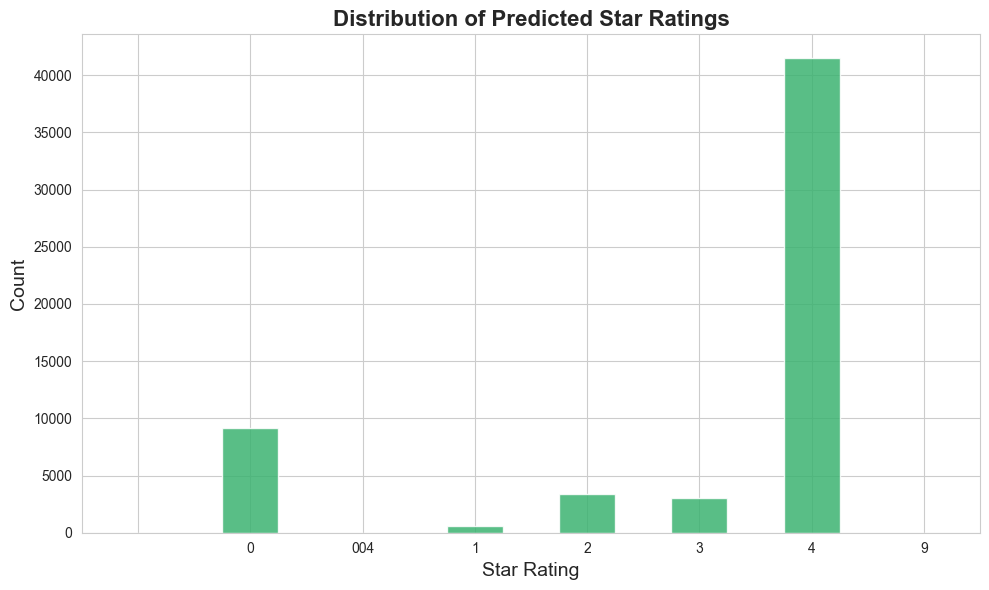

In [510]:
# Creating the bar plot to show distribution of star ratings given (we hope it matches the train dataset.. it does)
plt.figure(figsize=(10, 6))  # Setting an appropriate figure size for clearer visualization
pd.Series(stars_preds).value_counts().sort_index().plot(kind='bar', color="mediumseagreen", alpha=0.85)

# Adding titles, labels, and other aesthetics for clarity
plt.title('Distribution of Predicted Star Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)  # Ensures that the x-axis labels are horizontal
plt.tight_layout()

# Displaying the enhanced plot
plt.show()


In [ ]:
# note that our generative AI model is... generating predictions :) it has no forcing factor to not predict anything
#  outside of 0, 1, 2, 3, 4 but setting temperature to a low value limits this behavior. We do have some other levers here
#  that we aren't pulling but just calling it out 

In [518]:
cleaned_stars_pred = [s if s in ('0', '1', '2', '3', '4') else -1 for s in stars_preds]
# Accuracy
print((np.array(cleaned_stars_pred).astype(int) == test_df.head(len(cleaned_stars_pred))['completion'].astype(int)).mean())

# < 3 accuracy
print(((np.array(cleaned_stars_pred).astype(int) <= 3) == (test_df.head(len(cleaned_stars_pred))['completion'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(cleaned_stars_pred).astype(int) - test_df.head(len(cleaned_stars_pred))['completion'].astype(int)).abs() <= 1).mean())

0.7371253015812403
0.8197976151215871
0.8896776769131967


# 3.5 training - with system prompt

In [514]:
run_ft_model('I hated it', 'ft:gpt-3.5-turbo-0613:personal::8HM1JKgr', chat=True, system=system_prompt)
# note that chat models as of this point do not offer probabilities

('0', None)

In [ ]:
stars_preds = []

# Create a tqdm progress bar
pbar = tqdm(list(range(test_df.shape[0])), total=test_df.shape[0], desc="Processing rows")

# Loop through the dataframe
for index in pbar:
    if index < len(stars_preds):
        continue
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(row.review, 'ft:gpt-3.5-turbo-0613:personal::8HM1JKgr', chat=True, system=system_prompt)
    ground_truth = str(row.star).strip()
    stars_preds.append(model_pred)
    if index % 1_000 == 0:
        print(index)


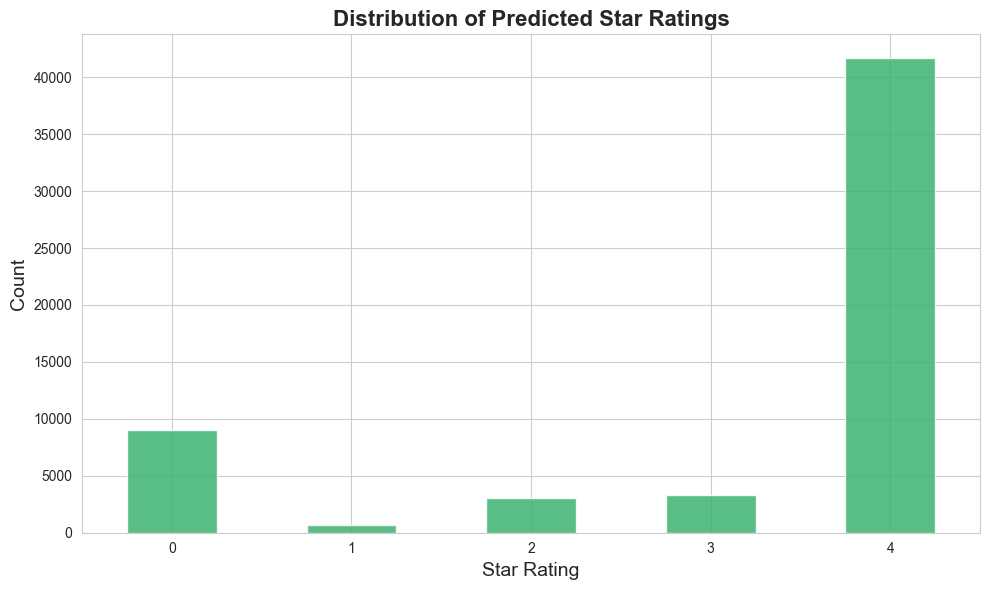

In [527]:
# Creating the bar plot to show distribution of star ratings given (we hope it matches the train dataset.. it does)
plt.figure(figsize=(10, 6))  # Setting an appropriate figure size for clearer visualization
pd.Series(stars_preds).value_counts().sort_index().plot(kind='bar', color="mediumseagreen", alpha=0.85)

# Adding titles, labels, and other aesthetics for clarity
plt.title('Distribution of Predicted Star Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)  # Ensures that the x-axis labels are horizontal
plt.tight_layout()

# Displaying the enhanced plot
plt.show()


In [528]:
cleaned_stars_pred = [s if s in ('0', '1', '2', '3', '4') else -1 for s in stars_preds]
# Accuracy
print((np.array(cleaned_stars_pred).astype(int) == test_df.head(len(cleaned_stars_pred))['completion'].astype(int)).mean())

# < 3 accuracy
print(((np.array(cleaned_stars_pred).astype(int) <= 3) == (test_df.head(len(cleaned_stars_pred))['completion'].astype(int) <= 3)).mean())

# Accuracy (off-by-1)
print(((np.array(cleaned_stars_pred).astype(int) - test_df.head(len(cleaned_stars_pred))['completion'].astype(int)).abs() <= 1).mean())

0.7366219429642615
0.8182875392706507
0.8909968236335549


In [536]:
train_price_usd = 0.008 * job.trained_tokens / 1_000
print(f'Price to train was ${train_price_usd}')

avg_tokens_per_input = job.trained_tokens / training_df.shape[0]
# output is always 1 token

avg_inference_price_usd = 0.0120 * (avg_tokens_per_input / 1_000) + (0.0160 / 1_000)
avg_inference_price_usd
print(f'Price for a single inference (on avg): ${avg_inference_price_usd} and cost to run test: ${avg_inference_price_usd * test_df.shape[0]}')

Price to train was $82.74736800000001
Price for a single inference (on avg): $0.0007341310468123514 and cost to run test: $42.295491999999996


In [568]:
import pandas as pd

# Create a dictionary with your data
data = {
    'Model Description': [
        'Babbage - 1 epoch',
        'Babbage - 4 epochs',
        '3.5 - 1 epoch + no system prompt',
        '3.5 - 1 epoch + system prompt'
    ],
    'Raw Accuracy': [
        0.7147171645288389,
        0.7197854650860049,
        0.7371253015812403,
        0.7366219429642615
    ],
    'Good vs Bad Accuracy': [
        0.8064152187874265,
        0.8088625830975648,
        0.8197976151215871,
        0.8182875392706507
    ],
    'One-off Accuracy': [
        0.8793327894745977,
        0.881103223230868,
        0.8896776769131967,
        0.8909968236335549
    ],
    'Cost to Fine-tune (USD)': [
        1.1334228,
        4.53,
        39.883296,
        82.75
    ],
    'Cost for a Single Inference (USD)': [
        2.7830718761390663e-05,
        2.7830718761390663e-05,
        0.00036213104681235143,
        0.0007341310468123514
    ],
    'Cost to Run Evaluation on Test Set (USD)': [
        1.6034112,
        1.6034112,
        20.863456000000003,
        42.295492
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# To make it more readable, let's round the numeric values to a fixed number of decimal places:
df_rounded = df.round(5)
df_rounded

,Model Description,Raw Accuracy,Good vs Bad Accuracy,One-off Accuracy,Cost to Fine-tune (USD),Cost for a Single Inference (USD),Cost to Run Evaluation on Test Set (USD)
0,Babbage - 1 epoch,0.71472,0.80642,0.87933,1.13342,0.00003,1.60341
1,Babbage - 4 epochs,0.71979,0.80886,0.88110,4.53000,0.00003,1.60341
2,3.5 - 1 epoch + no system prompt,0.73713,0.81980,0.88968,39.88330,0.00036,20.86346
3,3.5 - 1 epoch + system prompt,0.73662,0.81829,0.89100,82.75000,0.00073,42.29549


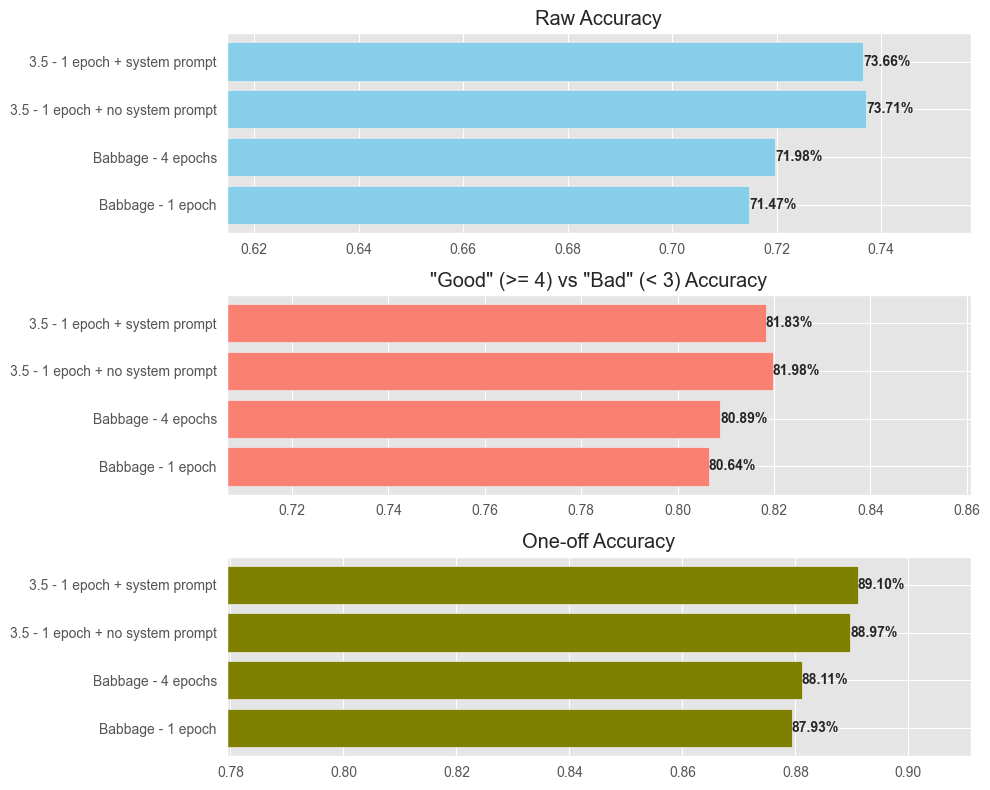

In [606]:
import matplotlib.pyplot as plt

# Find the minimum accuracy values for setting xlim
min_raw_accuracy = min(df_rounded['Raw Accuracy']) - 0.1
max_raw_accuracy = max(df_rounded['Raw Accuracy']) + .02
min_good_bad_accuracy = min(df_rounded['Good vs Bad Accuracy']) - 0.1
max_good_bad_accuracy = max(df_rounded['Good vs Bad Accuracy']) + .02
min_one_off_accuracy = min(df_rounded['One-off Accuracy']) - 0.1
max_one_off_accuracy = max(df_rounded['One-off Accuracy']) + .02

# Set the style
plt.style.use('ggplot')

# Define figure and axes for the accuracy subplots
fig_accuracy, axs_accuracy = plt.subplots(3, 1, figsize=(10, 8))  # Adjust the figure size as needed


axs_accuracy[0].barh(df_rounded['Model Description'], df_rounded['Raw Accuracy'], color='skyblue')
axs_accuracy[0].set_title('Raw Accuracy')
axs_accuracy[0].set_xlim(min_raw_accuracy, max_raw_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['Raw Accuracy']):
    axs_accuracy[0].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')

# Plot for Good vs Bad Accuracy
axs_accuracy[1].barh(df_rounded['Model Description'], df_rounded['Good vs Bad Accuracy'], color='salmon')
axs_accuracy[1].set_title('"Good" (>= 4) vs "Bad" (< 3) Accuracy')
axs_accuracy[1].set_xlim(min_good_bad_accuracy, )  # Extend the x-axis
for i, v in enumerate(df_rounded['Good vs Bad Accuracy']):
    axs_accuracy[1].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')
    
# Plot for One-off Accuracy
axs_accuracy[2].barh(df_rounded['Model Description'], df_rounded['One-off Accuracy'], color='olive')
axs_accuracy[2].set_title('One-off Accuracy')
axs_accuracy[2].set_xlim(min_one_off_accuracy, max_one_off_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['One-off Accuracy']):
    axs_accuracy[2].text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')
    
# Adjust the layout
plt.tight_layout()

# Show the plot for accuracies
plt.show()



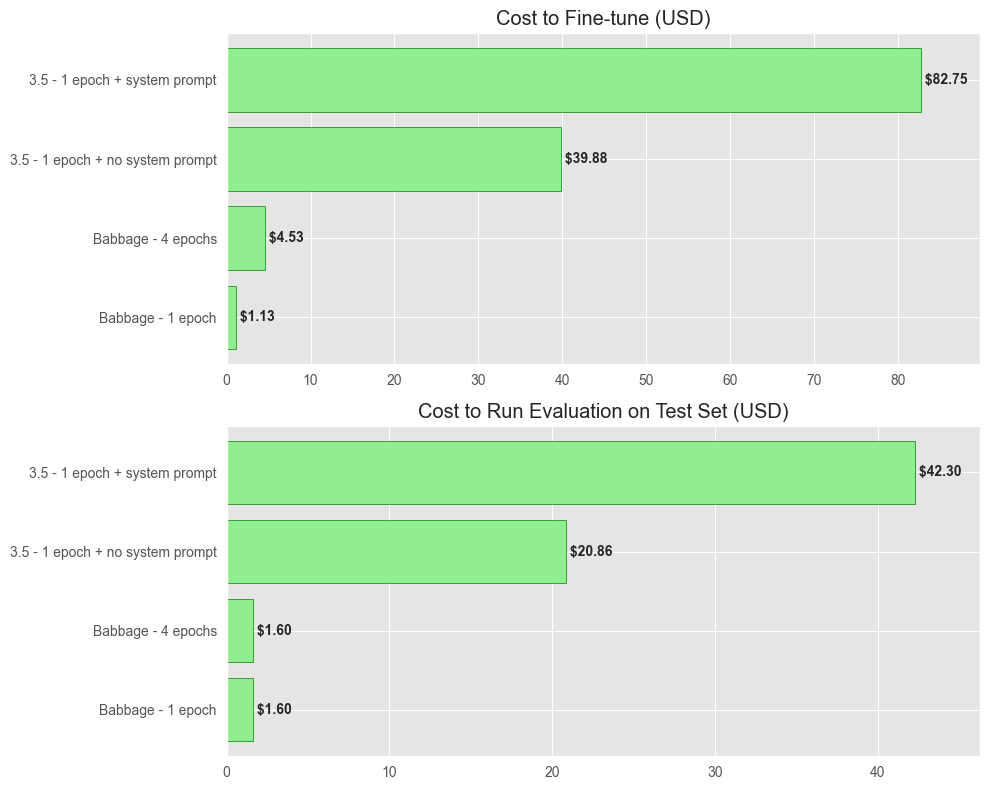

In [602]:
# Set the style
plt.style.use('ggplot')

max_fine_tune = max(df_rounded['Cost to Fine-tune (USD)']) + 7
max_eval = max(df_rounded['Cost to Run Evaluation on Test Set (USD)']) + 4

# Define figure and axes for the cost subplots
fig_cost, axs_cost = plt.subplots(2, 1, figsize=(10, 8))  # Adjust the figure size as needed

# Use a lighter green and specify a custom edgecolor for a bolder look
light_green_color = '#90ee90'  # Light green color code

# Plot for Cost to Fine-tune
axs_cost[0].barh(df_rounded['Model Description'], df_rounded['Cost to Fine-tune (USD)'], color=light_green_color, edgecolor='green')
axs_cost[0].set_title('Cost to Fine-tune (USD)')
axs_cost[0].set_xlim(0, max_fine_tune)  # Extend the x-axis

# Annotate with bold text
for i, v in enumerate(df_rounded['Cost to Fine-tune (USD)']):
    axs_cost[0].text(v, i, " ${:,.2f}".format(v), va='center', ha='left', fontweight='bold')

# Plot for Cost to Run Evaluation on Test Set
axs_cost[1].barh(df_rounded['Model Description'], df_rounded['Cost to Run Evaluation on Test Set (USD)'], color=light_green_color, edgecolor='green')
axs_cost[1].set_title('Cost to Run Evaluation on Test Set (USD)')
axs_cost[1].set_xlim(0, max_eval)  # Extend the x-axis

# Annotate with bold text
for i, v in enumerate(df_rounded['Cost to Run Evaluation on Test Set (USD)']):
    axs_cost[1].text(v, i, " ${:,.2f}".format(v), va='center', ha='left', fontweight='bold')

# Adjust the layout
plt.tight_layout()

# Show the plot for costs
plt.show()


# Using our model in the playground

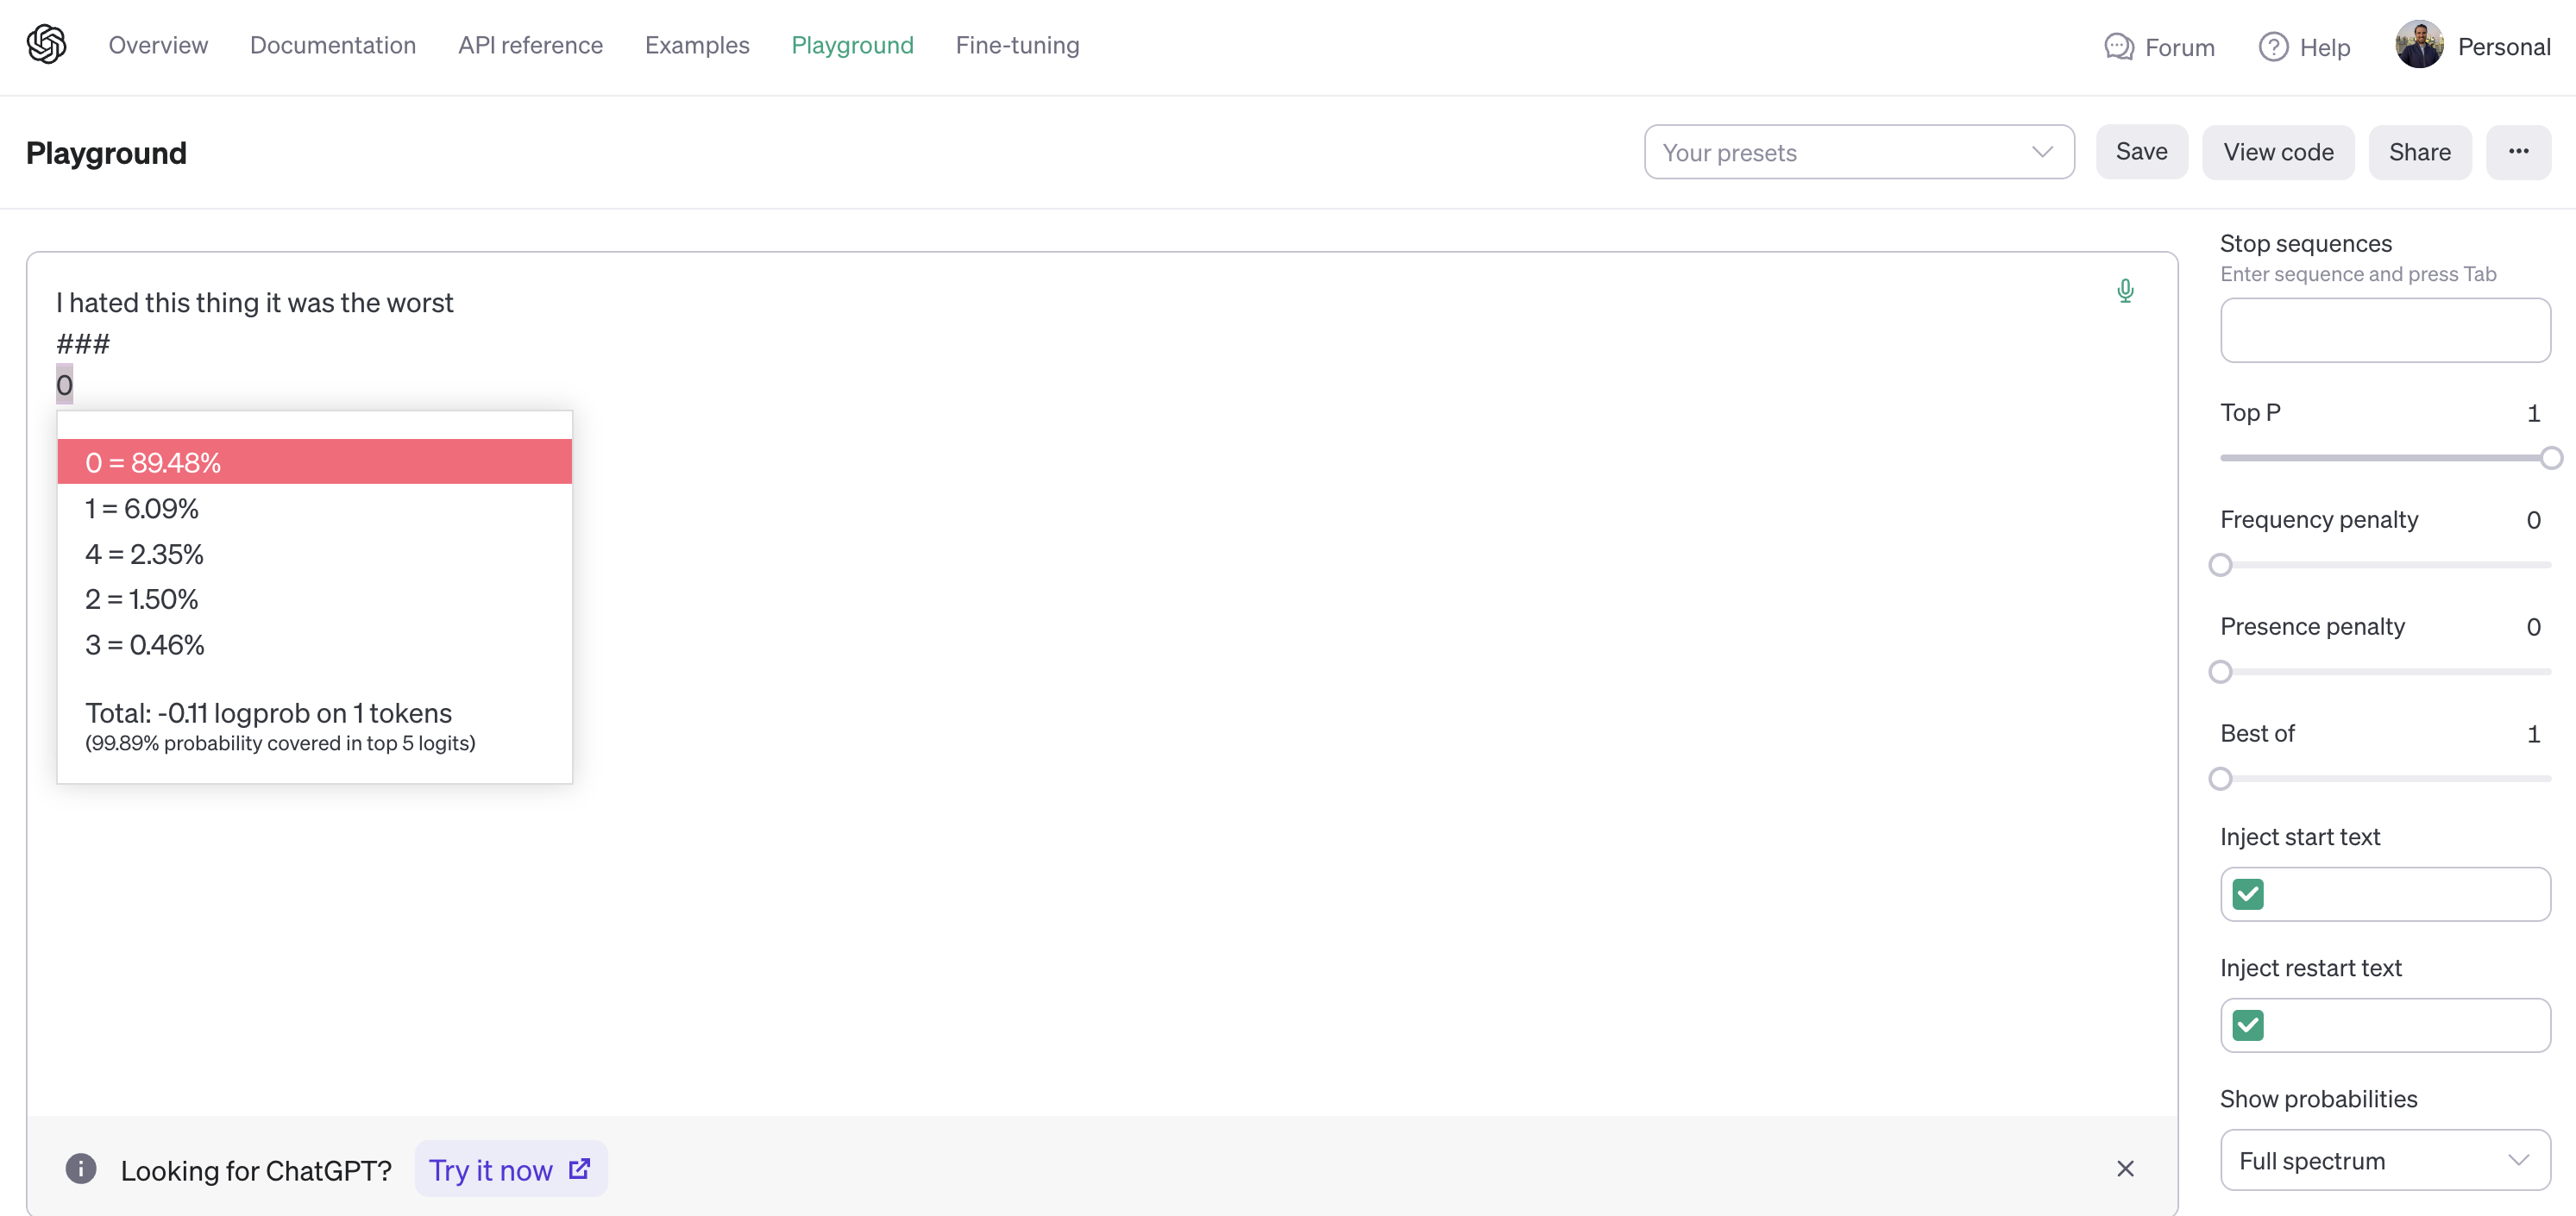